In [1]:
import sys
sys.path.append("../src")


In [2]:
# parallel_run.py
from __future__ import annotations
from dataclasses import asdict
from typing import Optional, Dict, Any, Tuple, List
import os

import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed

from stilbene_psd.io import CSVWaveformLoader
from stilbene_psd.preprocess import StilbenePreprocessor
from stilbene_psd.features import (
    DerivativeOnsetDetector,
    LinearInterpolationCrossingEstimator,
    TrapezoidalIntegrator,
    StilbeneFeatureExtractor,
)
from stilbene_psd.pipeline import BasicQualityGate

def process_one(event_id: int, path: str) -> Dict[str, Any]:
    """
    Procesa 1 archivo y regresa un dict listo para DataFrame (good o bad).
    Se construyen los objetos dentro del proceso (evita problemas de pickle).
    """
    try:
        loader = CSVWaveformLoader(header=1, col_t="(ns)", col_v="(mV)")
        pre = StilbenePreprocessor(smooth_window=31) #default

        onset = DerivativeOnsetDetector(min_puntos_negativos=50, factor_umbral=0.0005)
        crossing = LinearInterpolationCrossingEstimator()
        integrator = TrapezoidalIntegrator()

        extractor = StilbeneFeatureExtractor(onset_detector=onset, crossing=crossing, integrator=integrator)
        gate = BasicQualityGate(min_amplitude_mV=5.0)

        w = loader.load(event_id=event_id, path=path)
        pw = pre.process(w)
        feat = extractor.extract(pw)
        verdict = gate.check(pw, feat)

        row = feat.to_dict()
        row["passed"] = verdict.passed
        row["reject_reason"] = verdict.reason
        return row

    except Exception as e:
        return {
            "event_id": event_id,
            "path": path,
            "passed": False,
            "reject_reason": f"exception:{type(e).__name__}:{e}",
        }


In [3]:
def run_parallel(paths: List[str], max_workers: Optional[int] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    max_workers = número de procesos (núcleos). Si None, Python elige.
    """
    results: List[Dict[str, Any]] = []

    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(process_one, i, p) for i, p in enumerate(paths)]

        for fut in as_completed(futures):
            results.append(fut.result())

    df = pd.DataFrame(results)
    df_good = df[df["passed"] == True].copy()
    df_bad = df[df["passed"] == False].copy()
    return df_good, df_bad


In [4]:
from stilbene_psd.io import read_path_list


ruta = "/home/uri/Desktop/Dubna/Analisis_espectro/Picoscope_Stilbene/picoscope_stilbene_pu_c13/list_Stilbene_Rutas.txt"
paths = read_path_list(ruta)

# Usa todos los núcleos menos 1 (práctico para no congelar la PC)
workers = max(1, (os.cpu_count() or 2) - 1)

df_good, df_bad = run_parallel(paths, max_workers=workers)

print("Good:", len(df_good), "Bad:", len(df_bad))
print(df_bad["reject_reason"].value_counts().head(15))

df_good.to_csv("features_good.csv", index=False)
df_bad.to_csv("features_bad.csv", index=False)
print("Saved features_good.csv and features_bad.csv")
print(workers)
    
#window 31
#16146 50 y umbral 0.001
#16329 min_descenso 50  y umbral 0.0005 con amplitudmin de 5 
#15499 min_descenso 50  y umbral 0.0005 con amplitudmin de 15  (descartar mas ruido)
#13057 min_descenso 50  y umbral 0.0005 con amplitudmin de 20 
#10870 min_descenso 50  y umbral 0.0005 con amplitudmin de 25 

#14099 min_descenso 50  y umbral 0.0005 con amplitudmin de 5 window 50
#10832 min_descenso 17  y umbral 0.0005 con amplitudmin de 5 window 17




Good: 16329 Bad: 23671
reject_reason
no_onset_found                                                        13919
no_t10_t90_rise                                                        9359
no_t90_t10_fall                                                         362
exception:ValueError:too_many_infinite_values_in_voltage: 535 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 473 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 169 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 432 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 731 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 448 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 843 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 615 > 50        1
exception:ValueError:too_many_infinite_values_in_voltage: 313 > 50        1
exception:ValueError:too_many_infinite_values_in_vo

Silhouette: {2: 0.5127984318719598, 3: 0.4649871200950699, 4: 0.43623200401285334, 5: 0.4000355585366329}


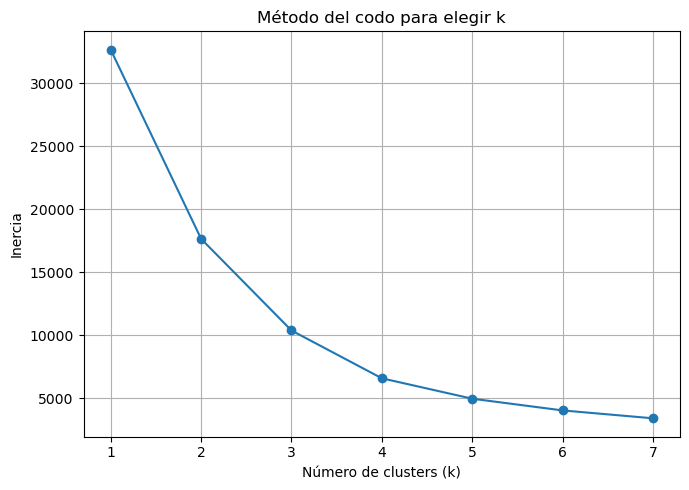

              psd                       q_total                   
             mean       std  count         mean         std  count
cluster                                                           
0.0      0.583633  0.022191  12510 -9085.848816  197.816049  12510
1.0      0.535837  0.026010   3819 -8164.363766  747.923895   3819
Plot not saved (no path provided).


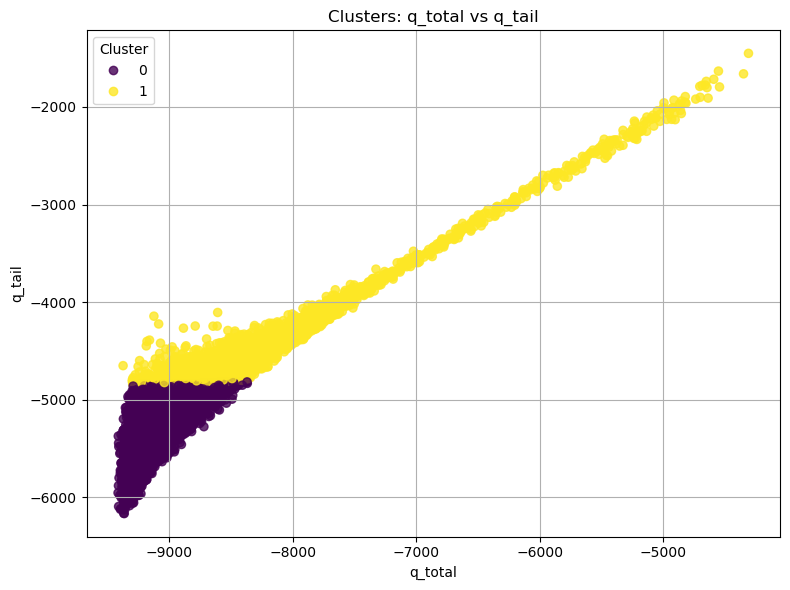

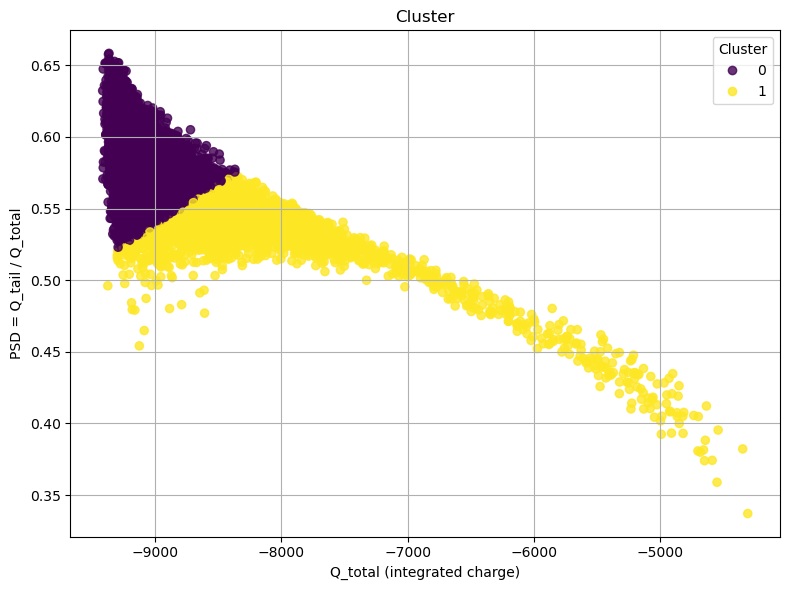

Saved features_with_clusters.csv


In [5]:
import pandas as pd

from stilbene_psd.ml import KMeansClusterer, ModelSelector
from stilbene_psd.viz import ClusteringPlotter


def main():
    df = pd.read_csv("features_good.csv")

    # Core features for PSD clustering:
    # (you can also try using PSD + q_total instead of q_total + q_tail)
    #feature_cols = ["q_total", "q_tail"]
    feature_cols = ["psd","q_total"]
    X = df[feature_cols].dropna().copy()

    # scale once for elbow/silhouette
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    selector = ModelSelector(random_state=42, n_init=10)
    k_range = range(1, 8)
    inertias = selector.elbow_inertias(X_scaled, k_range)
    sils = selector.silhouettes(X_scaled, ks=[2, 3, 4, 5])

    print("Silhouette:", sils)

    plotter = ClusteringPlotter()
    plotter.plot_elbow(k_range, inertias)

    # Choose k (e.g. 2)
    clusterer = KMeansClusterer(random_state=42, n_init=10)
    res = clusterer.fit_predict(X, n_clusters=2)

    df.loc[X.index, "cluster"] = res.labels

    # Stats
    stats = df.groupby("cluster")[feature_cols].agg(["mean", "std", "count"])
    print(stats)

    # Scatter
    plotter.plot_scatter(df.loc[X.index], "q_total", "q_tail", label_col="cluster")
    #plotter.plot_scatter(df.loc[X.index], "q_total", "psd", label_col="cluster")
    plotter.plot_scatter(df.loc[X.index], "q_total","psd", label_col="cluster",title="Cluster",
                         xlabel="Q_total (integrated charge)", ylabel="PSD = Q_tail / Q_total", save="cluster.pdf")
    

    df.to_csv("features_with_clusters.csv", index=False)
    print("Saved features_with_clusters.csv")


if __name__ == "__main__":
    main()


In [6]:
import matplotlib.pyplot as plt
ruta_cluster="/home/uri/Desktop/Dubna/proyectos_congreso/Clas_Neutrones_Gamma_cloustering/notebooks/features_with_clusters.csv"

In [7]:
df_cluster= pd.read_csv(ruta_cluster, header=0)
df_cluster0=df_cluster[df_cluster["cluster"]==0].reset_index(drop=True)
df_cluster= pd.read_csv(ruta_cluster, header=0)
df_cluster1=df_cluster[df_cluster["cluster"]==1].reset_index(drop=True)

In [8]:
df_cluster1.columns

Index(['event_id', 'path', 'baseline_mV', 'amplitude_mV', 't_min_ns', 't0_ns',
       't10_ns', 't90_ns', 'rise_time_ns', 't90_f_ns', 't10_f_ns',
       'fall_time_ns', 'q_total', 'q_tail', 'psd', 'valid', 'invalid_reason',
       'passed', 'reject_reason', 'cluster'],
      dtype='object')

In [9]:
# Guardar solo la columna "Evento_Funcion_Onda" sin nombres de columna
df_cluster0["path"].to_csv('cluster0.txt', index=False, header=False)
df_cluster1["path"].to_csv('cluster1.txt', index=False, header=False)

<Axes: >

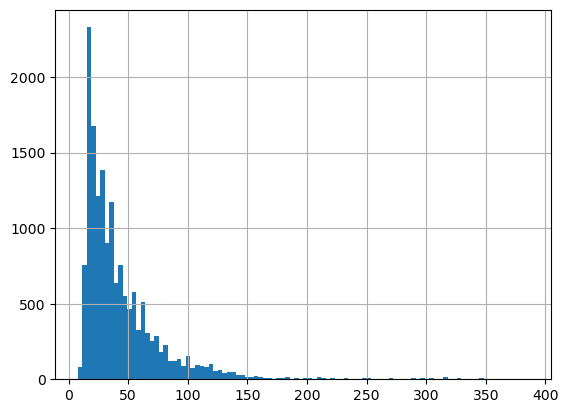

In [10]:
df_good["amplitude_mV"].hist(bins=100)

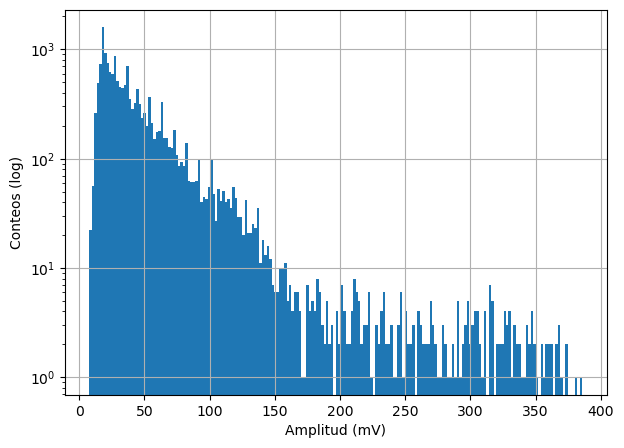

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(df_good["amplitude_mV"], bins=200, log=True)
plt.xlabel("Amplitud (mV)")
plt.ylabel("Conteos (log)")
plt.grid(True)
plt.show()


In [12]:
dyudyui

NameError: name 'dyudyui' is not defined

In [ ]:
for i in range(0,len(df_cluster1["path"])):
#for i in range(10):
    df= pd.read_csv(df_cluster1["path"][i], header=1)
     # CONVERTIR COLUMNAS A NUMÉRICAS (SOLUCIÓN AL ERROR)
    df["(mV)"] = pd.to_numeric(df["(mV)"], errors='coerce')
    df["(ns)"] = pd.to_numeric(df["(ns)"], errors='coerce')
    plt.plot(df["(ns)"], df["(mV)"], alpha=0.4, label="Señal original")